In [30]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [31]:
import librosa
import pandas as pd
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM, GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras import optimizers

In [32]:
#DataFlair - Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [33]:
#DataFlair - Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
gender = ['female_','male_']
#DataFlair - Emotions to observe
#observed_emotions=['calm', 'happy', 'fearful', 'disgust', 'sad', 'angry','surprised','neutral']

In [34]:
from pydub import AudioSegment
for file in glob.glob("E:/Bhuvan/Rawdata/Actor_*/*.wav"):
  sound = AudioSegment.from_wav(file)
  sound = sound.set_channels(1)
  sound.export(file, format="wav")

In [35]:
#DataFlair - Load the data and extract features for each sound file
def load_data(test_size):
    x,y=[],[]
    for file in glob.glob("E:/Bhuvan/Rawdata/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        temp = file_name.split("-")[6]
        temp = temp[:2]
        emotion = ''
        emotion = emotion + gender[int(temp) % 2]
        emotion = emotion + emotions[file_name.split("-")[2]]

        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [36]:
#DataFlair - Split the dataset
x_train,x_test,y_train,y_test=load_data(0.1)

In [37]:
#DataFlair - Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

(1296, 144)


In [38]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [39]:
x_train.shape

(1296, 180)

In [40]:
x_train =np.expand_dims(x_train, axis=2)
x_test= np.expand_dims(x_test, axis=2)

In [41]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [42]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(180,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(BatchNormalization(input_shape=(180,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(BatchNormalization(input_shape=(180,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(BatchNormalization(input_shape=(180,1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(16))
model.add(Activation('softmax'))

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 180, 256)          1536      
_________________________________________________________________
activation_7 (Activation)    (None, 180, 256)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 180, 128)          163968    
_________________________________________________________________
batch_normalization_3 (Batch (None, 180, 128)          512       
_________________________________________________________________
activation_8 (Activation)    (None, 180, 128)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 180, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 22, 128)          

In [44]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.01,decay=1e-3), metrics=['acc'])

In [45]:
cnnhistory=model.fit(x_train, y_train, batch_size=32, epochs=500, validation_split=0.1)

Epoch 1/500
37/37 [==============================] - 4s 90ms/step - loss: 3.1118 - acc: 0.0858 - val_loss: 2.9775 - val_acc: 0.0923
Epoch 2/500
37/37 [==============================] - 3s 78ms/step - loss: 2.8642 - acc: 0.0849 - val_loss: 3.2793 - val_acc: 0.0615
Epoch 3/500
37/37 [==============================] - 3s 86ms/step - loss: 2.7582 - acc: 0.1201 - val_loss: 2.8329 - val_acc: 0.0538
Epoch 4/500
37/37 [==============================] - 3s 81ms/step - loss: 2.6660 - acc: 0.1261 - val_loss: 2.7487 - val_acc: 0.0846
Epoch 5/500
37/37 [==============================] - 3s 90ms/step - loss: 2.4890 - acc: 0.1647 - val_loss: 2.7272 - val_acc: 0.0769
Epoch 6/500
37/37 [==============================] - 3s 81ms/step - loss: 2.4286 - acc: 0.1810 - val_loss: 2.5162 - val_acc: 0.1154
Epoch 7/500
37/37 [==============================] - 3s 92ms/step - loss: 2.2731 - acc: 0.2204 - val_loss: 2.3792 - val_acc: 0.1769
Epoch 8/500
37/37 [==============================] - 4s 96ms/step - loss: 2.

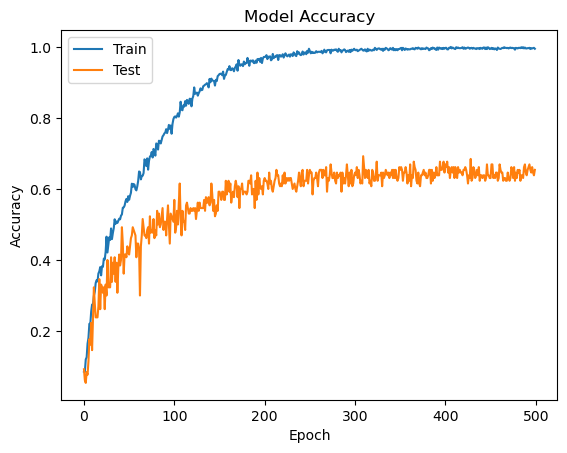

In [46]:
plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

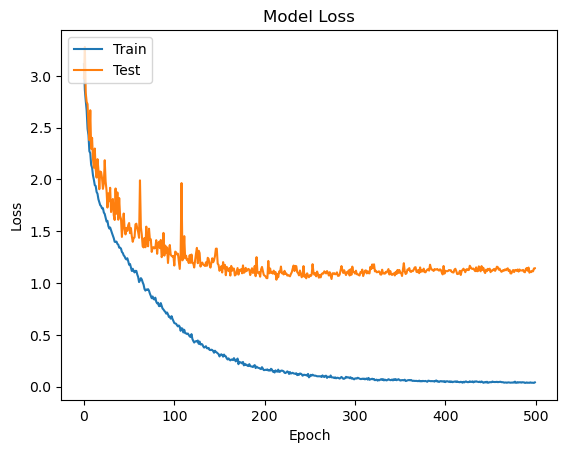

In [47]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [48]:
model_name = 'CNN.h5'
save_dir = os.path.join(os.getcwd(), 'E:/Bhuvan/MODELS')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at E:/Bhuvan/MODELS\CNN.h5 


In [49]:
#livedf= pd.DataFrame(columns=['feature'])

mfccs = extract_feature('E:/Bhuvan/Rawdata/Actor_19/03-01-03-01-01-02-19.wav',mfcc=True, chroma=True, mel=True)
featurelive = mfccs
livedf2 = featurelive

In [50]:
livedf2= pd.DataFrame(data=livedf2)

In [51]:
livedf2 = livedf2.stack().to_frame().T

In [52]:
twodim= np.expand_dims(livedf2, axis=2)

In [53]:
livepreds = model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 112ms/step


In [54]:
livepreds1=livepreds.argmax(axis=1)

In [55]:
liveabc = livepreds1.astype(int).flatten()

In [56]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_happy'], dtype='<U16')

In [ ]:
x_test.shape

In [57]:
loss, acc = model.evaluate(x_test, y_test)
print('Test Loss: %.2f \nTest Accuracy: %.2f' % ((loss),(acc*100)))

5/5 [==============================] - 0s 17ms/step - loss: 0.9661 - acc: 0.7014
Test Loss: 0.97 
Test Accuracy: 70.14
